# TP4

#Imports

In [1]:
install.packages("xgboost")
library(xgboost)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [2]:
install.packages("randomForest")
library("randomForest")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

randomForest 4.7-1.2

Type rfNews() to see new features/changes/bug fixes.



In [3]:
install.packages("e1071")
library(e1071)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependency ‘proxy’




In [4]:
library(knitr)

In [5]:
load("/content/TP4.Rdata")
ls()

[1] "diag_test"  "diag_train" "esp_test"   "esp_train"  "RRL"

### Funciones Auxiliares K-Fold

In [6]:
k_fold_cv_xgboost <- function(data, column, folds, XGB.eta, XGB.nrounds, XGB.max.depth, num_folds = 5) {
  # Inicializar vector para almacenar la precisión de cada pliegue
  accuracies <- numeric(num_folds)

  for (i in 1:num_folds) {
      # Separar los datos de entrenamiento y validación
      test_indices <- which(folds == i, arr.ind = TRUE)
      test_data <- data[test_indices, ]
      train_data <- data[-test_indices, ]

      test_x <- test_data[, -ncol(test_data)]    # Todas las columnas menos la clase
      test_y <- test_data[[column]]

      m.xgb <- xgboost(
        data = as.matrix(train_data[, -ncol(train_data)]),
        label = as.integer(train_data[[column]]) - 1,
        objective = "binary:hinge",
        nrounds = XGB.nrounds,
        early_stopping_rounds = 1000,
        eta = XGB.eta,
        max.depth = XGB.max.depth,
        colsample_bytree = 1,
        verbose = 0,
        subsample = 1
      )

      test_pred <- predict(m.xgb, as.matrix(test_x))
      error <- mean(test_pred != (as.integer(test_y) - 1))
      accuracies[i] <- error
    }

    # Retornar la precisión promedio de todos los pliegues
    mean_accuracy <- mean(accuracies)
    return(mean_accuracy)
}

In [7]:
k_fold_cv_svm_RBF <- function(data, column, folds, c, gamma, num_folds = 5) {
  # Inicializar vector para almacenar la precisión de cada pliegue
  accuracies <- numeric(num_folds)

  for (i in 1:num_folds) {
      # Separar los datos de entrenamiento y validación
      test_indices <- which(folds == i, arr.ind = TRUE)
      test_data <- data[test_indices, ]
      train_data <- data[-test_indices, ]

      test_x <- test_data[, -ncol(test_data)]    # Todas las columnas menos la clase
      test_y <- test_data[[column]]

      svm_model <- svm(
        as.formula(paste(column, "~ .")),
        data = train_data,
        type = 'C-classification',
        kernel = "radial",
        cost = c,
        gamma = gamma
      )

      test_pred <- predict(svm_model, test_x)
      error <- mean(test_pred != test_y)
      accuracies[i] <- error
    }

    # Retornar la precisión promedio de todos los pliegues
    mean_accuracy <- mean(accuracies)
    return(mean_accuracy)
}

In [8]:
k_fold_cv_svm_polinomial <- function(data, column, folds, c, gamma, k, num_folds = 5) {
  # Inicializar vector para almacenar la precisión de cada pliegue
  accuracies <- numeric(num_folds)

  for (i in 1:num_folds) {
      # Separar los datos de entrenamiento y validación
      test_indices <- which(folds == i, arr.ind = TRUE)
      test_data <- data[test_indices, ]
      train_data <- data[-test_indices, ]

      test_x <- test_data[, -ncol(test_data)]    # Todas las columnas menos la clase
      test_y <- test_data[[column]]

      svm_model <- svm(
        as.formula(paste(column, "~ .")),
        data = train_data,
        type = 'C-classification',
        kernel = "polynomial",
        degree = k,
        cost = c,
        gamma = gamma
      )

      test_pred <- predict(svm_model, test_x)
      error <- mean(test_pred != test_y)
      accuracies[i] <- error
    }

    # Retornar la precisión promedio de todos los pliegues
    mean_accuracy <- mean(accuracies)
    return(mean_accuracy)
}

# Ej 1

## Espirales

### Predicción

In [ ]:
maxProf <- 20
XGB.nrounds <- 200 #total de arboles/ciclos
XGB.eta <- 0.1 #learning rate, similar a redes

x.train <- as.matrix(esp_train[,1:2])
y.train <- esp_train[,3]

x.test <- as.matrix(esp_test[, 1:2])
y.test <- esp_test[, 3]

errors_train <- numeric(maxProf)
errors_test <- numeric(maxProf)

for (XGB.max.depth in 1:maxProf) {
  m.xgb <- xgboost(
    data = x.train,
    label = as.integer(y.train) - 1,
    objective = "binary:hinge",
    nrounds = XGB.nrounds,
    early_stopping_rounds = 1000,
    eta = XGB.eta,
    max.depth = XGB.max.depth,
    colsample_bytree = 1,
    verbose = 0,
    subsample = 1
  )

  train.pred <- predict(m.xgb, x.train)
  error <- mean(train.pred != (as.integer(y.train) - 1))
  errors_train[XGB.max.depth] <- error

  test.pred <- predict(m.xgb, x.test)
  error <- mean(test.pred != (as.integer(y.test) - 1))
  errors_test[XGB.max.depth] <- error
}

### Gráfica

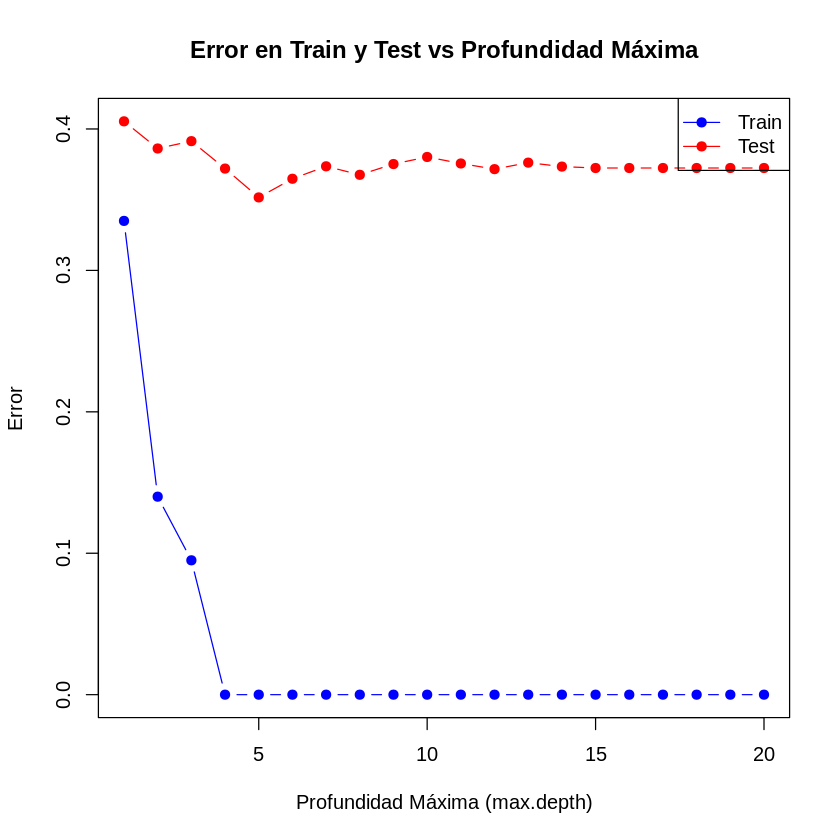

In [ ]:
plot(
  1:maxProf,
  errors_train,
  type = "b",
  col = "blue",
  pch = 19,
  xlab = "Profundidad Máxima (max.depth)",
  ylab = "Error",
  main = "Error en Train y Test vs Profundidad Máxima",
  ylim = range(c(errors_train, errors_test))
)

lines(
  1:maxProf,
  errors_test,
  type = "b",
  col = "red",
  pch = 19
)

legend(
  "topright",
  legend = c("Train", "Test"),
  col = c("blue", "red"),
  pch = 19,
  lty = 1
)

### Análisis
Podemos ver que a partir de una profundidad de 5 los resultados en test empeoran levementes quedando estables a partir de 14 de profundidad. El error de train llega a cero en la profundidad 4.

Lo que puedo ver es que tener árboles muy complejos empeora el resultado un poco pero a partir de cierta profundidad queda estable, probablemente porque al tener pocos puntos cada árbol esta haciendo un overfitting completo de los datos, incluido los puntos ruidosos. Al usar menos profundidad en los árboles se hace un menor overfitting en cada árbol particular al ruído que tiene el dataset lo que permite que el algoritmo aprenda entre cada iteración.

## Diagonales

### Predicción

In [ ]:
maxProf <- 20
XGB.nrounds <- 200 #total de arboles/ciclos
XGB.eta <- 0.1 #learning rate, similar a redes

x.train <- as.matrix(diag_train[,1:2])
y.train <- diag_train[,3]

x.test <- as.matrix(diag_test[, 1:2])
y.test <- diag_test[, 3]

errors_train <- numeric(maxProf)
errors_test <- numeric(maxProf)

for (XGB.max.depth in 1:maxProf) {
  m.xgb <- xgboost(
    data = x.train,
    label = as.integer(y.train) - 1,
    objective = "binary:hinge",
    nrounds = XGB.nrounds,
    early_stopping_rounds = 1000,
    eta = XGB.eta,
    max.depth = XGB.max.depth,
    colsample_bytree = 1,
    verbose = 0,
    subsample = 1
  )

  train.pred <- predict(m.xgb, x.train)
  error <- mean(train.pred != (as.integer(y.train) - 1))
  errors_train[XGB.max.depth] <- error

  test.pred <- predict(m.xgb, x.test)
  error <- mean(test.pred != (as.integer(y.test) - 1))
  errors_test[XGB.max.depth] <- error
}

### Gráfica

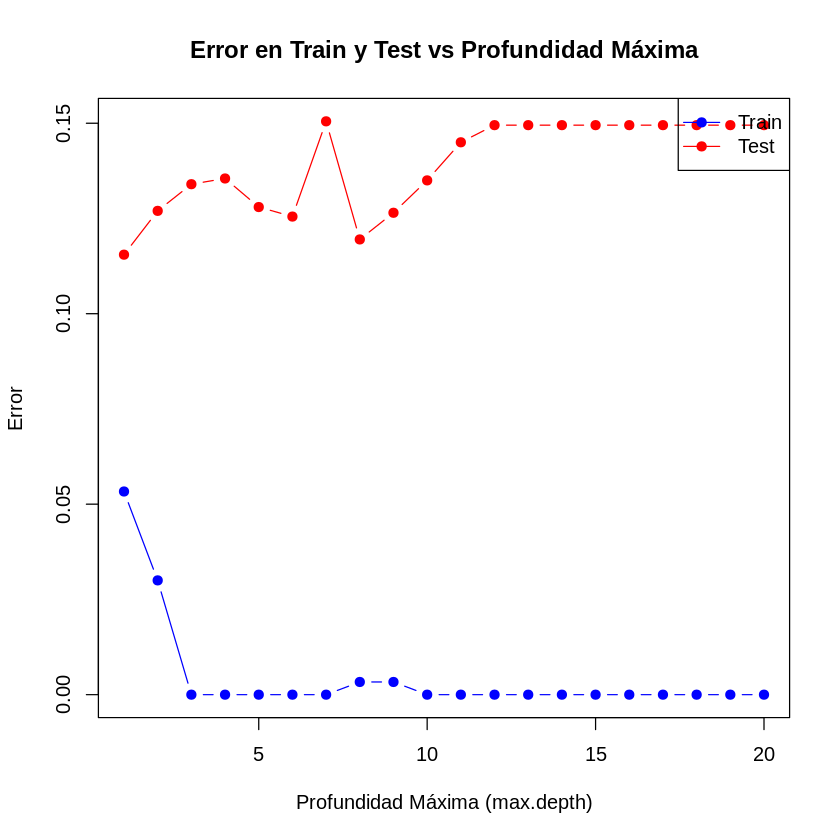

In [ ]:
plot(
  1:maxProf,
  errors_train,
  type = "b",
  col = "blue",
  pch = 19,
  xlab = "Profundidad Máxima (max.depth)",
  ylab = "Error",
  main = "Error en Train y Test vs Profundidad Máxima",
  ylim = range(c(errors_train, errors_test))
)

lines(
  1:maxProf,
  errors_test,
  type = "b",
  col = "red",
  pch = 19
)

legend(
  "topright",
  legend = c("Train", "Test"),
  col = c("blue", "red"),
  pch = 19,
  lty = 1
)

### Análisis
En este dataset podemos ver como aumentar la profundidad claramente empeoran los resultados ya que los árboles de profundidad 1 son los que obtuvieron el mejor desempeño.

Cuando los árboles se vuelven muy grandes debe estar ocurriendo un overfitting al igual que en el problema anterior, donde todos los puntos son bien clasificados incluidos los ruidosos, a partir de ese punto el método deja de aprender ya que no hay errores para minimizar.

## Análisis general Ej 1

Claramente al aumentar la profundidad de los árboles el clasificador empeora debido a que los weaklearners estan dejando de ser simples y de tener un problema de sesgo a ser muy complejos y empezar a tener mas varianza y overfitting (cada árbol de forma individual) haciendo que se deje de dar mas prioridad a puntos "mal clasificados" debido a que estamos clasificando todos "correctamente" (inlcuso los puntos ruidosos).

# Ej 2

In [ ]:
mtry_values <- floor((ncol(RRL)-1) * (1 / 2)^(0:6))
errors_avg <- c()
tree_count <- 1000
num_runs <- 5

for (mtry in mtry_values) {
  errors <- numeric(num_runs)

  for (i in 1:num_runs) {
    rf_model <- randomForest(
      Tipo ~ .,
      data = RRL,
      mtry = mtry,
      ntree = tree_count
    )

    errors[i] <- rf_model$err.rate[nrow(rf_model$err.rate), "OOB"]
  }
  errors_avg <- c(errors_avg, mean(errors))
}

In [ ]:
for (i in 1:length(mtry_values)) {
  cat("Mtry", mtry_values[i], "had error", errors_avg[i], "\n")
}

Mtry 69 had error 0.04235127 
Mtry 34 had error 0.03926346 
Mtry 17 had error 0.03926346 
Mtry 8 had error 0.03909348 
Mtry 4 had error 0.03971671 
Mtry 2 had error 0.04164306 
Mtry 1 had error 0.04589235 


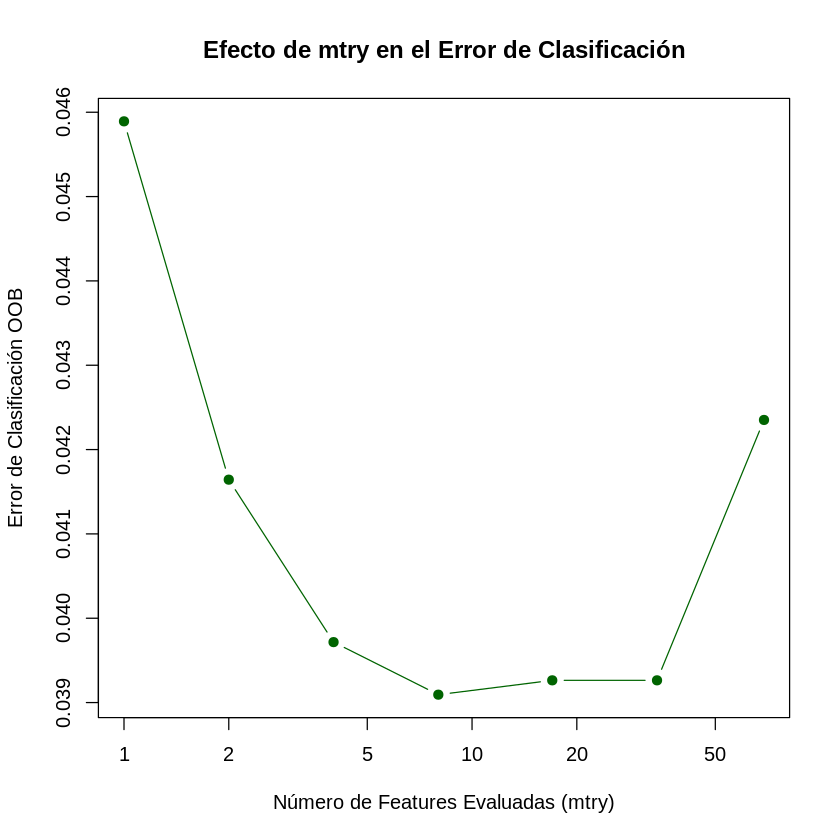

In [ ]:
plot(
  mtry_values,
  errors_avg,
  type = "b",
  xlab = "Número de Features Evaluadas (mtry)",
  ylab = "Error de Clasificación OOB",
  main = "Efecto de mtry en el Error de Clasificación",
  col = "darkgreen",
  pch = 19,
  log = "x"
)


## Análisis
Como era esperable el mejor resultado se dió con un mtry de 8 que es el valor mas cercano a la raiz cuadrada de 69 que es el valor por defecto utilizado normalmente.

Al utilizar una única feature en cada paso estamos teniendo un error muy malo ya que en ningún momento decidimos cual es la mejor variable para realizar un corte (ya sea usando entropia o gini) si no que siempre usamos la variable aleatoria que obtenemos.

Al utilizar las 69 variables estamos replicando Bagging y se puede apreciar como la poca varianza entre los árboles que genera hace que el error sea peor.

Para los otros valores podemos ver que todos son bastante buenos menos el de 2 variables ya que este recae en el mismo problema que elegir una sola.

Esto nos demuestra que el método random forest es muy bueno ya que tiene un único parametro a optimizar y realmente podríamos usar el recomendado de sqrt(p) y obtener un muy buen modelo sin tener que optimizar nada.

# Ej 3

## Cargar Dataset

Como primero tenemos que buscar los mejores parámetros para los distintos métodos y luego comparar los resultados entre ellos, decidí dividir el dataset en 80% para optimizacion de parámetros y entrenamiento de los mejores modelos y dejar el 20% restante para poder evaluarlos y compararlos con un conjunto de datos independiente. Con este problema hace que se complique porque tenemos pocos puntos, y dedicar el 20% (9 puntos) para testing nos deja con solo 40 puntos para entrenar.

In [222]:
load("/content/lampone.Rdata")
#summary(lampone)
lampone <- lampone[sample(1:nrow(lampone)), ]
lampone <- lampone[, -c(1, 144)]

test_indices <- sample(1:nrow(lampone), size = (0.2 * nrow(lampone)))
test <- lampone[test_indices, ]
train <- lampone[-test_indices, ]

In [223]:
nrow(test)
nrow(train)

[1] 9

[1] 40

## Optimizacion de parámetros

### Random Forest

Para RandomForest simplemente decidimos la profundidad según el OOB error mas bajo

In [224]:
results <- data.frame(Mtry = numeric(), Error = numeric(), stringsAsFactors = FALSE)

mtry_values <- floor((ncol(train)-1) * (1 / 2)^(0:7))
errors_avg <- c()
tree_count <- 1000
num_runs <- 5

for (mtry in mtry_values) {
  errors <- numeric(num_runs)

  for (i in 1:num_runs) {
    rf_model <- randomForest(
      N_tipo ~ .,
      data=train,
      mtry = mtry,
      ntree = tree_count
    )

    errors[i] <- rf_model$err.rate[nrow(rf_model$err.rate), "OOB"]
  }
  errors_avg <- c(errors_avg, mean(errors))
  results <- rbind(results, data.frame(Mtry = mtry, Error = errors_avg[length(errors_avg)]))
}

In [225]:
print(kable(results, format.args = list(scientific = FALSE), align = "r"))



| Mtry| Error|
|----:|-----:|
|  141| 0.125|
|   70| 0.140|
|   35| 0.120|
|   17| 0.105|
|    8| 0.110|
|    4| 0.105|
|    2| 0.140|
|    1| 0.155|


In [226]:
min_error <- min(results$Error)
best_results_rf <- results[results$Error == min_error, ]
print(kable(best_results_rf, format.args = list(scientific = FALSE), align = "r"))



|   | Mtry| Error|
|:--|----:|-----:|
|4  |   17| 0.105|


Para random forest determinamos que 17 variables era el mejor resultado, siendo este valor muy cercano a la raiz cuadrada de 141.

### XGBoosting

Para XGBoosting voy a utilizar 5-fold cross validation para estimar los errores.

In [227]:
results <- data.frame(LearningRate = numeric(), Prof = integer(), Error = numeric(), stringsAsFactors = FALSE)

nrounds <- 500
learning_rates <- c(0.01, 0.05, 0.1, 0.3)
profs <- 1:20
num_folds <- 5
folds <- cut(seq(1, nrow(train)), breaks = num_folds, labels = FALSE)

for(i in 1:length(learning_rates)) {
  for(j in 1:length(profs)) {
    error_kfold <- k_fold_cv_xgboost(train, "N_tipo", folds, learning_rates[i], nrounds, profs[j], num_folds)
    results <- rbind(results, data.frame(LearningRate = learning_rates[i], Prof = profs[j], Error = error_kfold))
  }
}

In [228]:
print(kable(results, format.args = list(scientific = FALSE), align = "r"))



| LearningRate| Prof| Error|
|------------:|----:|-----:|
|         0.01|    1| 0.250|
|         0.01|    2| 0.175|
|         0.01|    3| 0.175|
|         0.01|    4| 0.175|
|         0.01|    5| 0.175|
|         0.01|    6| 0.175|
|         0.01|    7| 0.175|
|         0.01|    8| 0.175|
|         0.01|    9| 0.175|
|         0.01|   10| 0.175|
|         0.01|   11| 0.175|
|         0.01|   12| 0.175|
|         0.01|   13| 0.175|
|         0.01|   14| 0.175|
|         0.01|   15| 0.175|
|         0.01|   16| 0.175|
|         0.01|   17| 0.175|
|         0.01|   18| 0.175|
|         0.01|   19| 0.175|
|         0.01|   20| 0.175|
|         0.05|    1| 0.250|
|         0.05|    2| 0.175|
|         0.05|    3| 0.175|
|         0.05|    4| 0.175|
|         0.05|    5| 0.175|
|         0.05|    6| 0.175|
|         0.05|    7| 0.175|
|         0.05|    8| 0.175|
|         0.05|    9| 0.175|
|         0.05|   10| 0.175|
|         0.05|   11| 0.175|
|         0.05|   12| 0.175|
|         0.

In [229]:
min_error <- min(results$Error)
best_results_xgb <- results[results$Error == min_error, ]
print(kable(best_results_xgb, format.args = list(scientific = FALSE), align = "r"))



|   | LearningRate| Prof| Error|
|:--|------------:|----:|-----:|
|2  |         0.01|    2| 0.175|
|3  |         0.01|    3| 0.175|
|4  |         0.01|    4| 0.175|
|5  |         0.01|    5| 0.175|
|6  |         0.01|    6| 0.175|
|7  |         0.01|    7| 0.175|
|8  |         0.01|    8| 0.175|
|9  |         0.01|    9| 0.175|
|10 |         0.01|   10| 0.175|
|11 |         0.01|   11| 0.175|
|12 |         0.01|   12| 0.175|
|13 |         0.01|   13| 0.175|
|14 |         0.01|   14| 0.175|
|15 |         0.01|   15| 0.175|
|16 |         0.01|   16| 0.175|
|17 |         0.01|   17| 0.175|
|18 |         0.01|   18| 0.175|
|19 |         0.01|   19| 0.175|
|20 |         0.01|   20| 0.175|
|22 |         0.05|    2| 0.175|
|23 |         0.05|    3| 0.175|
|24 |         0.05|    4| 0.175|
|25 |         0.05|    5| 0.175|
|26 |         0.05|    6| 0.175|
|27 |         0.05|    7| 0.175|
|28 |         0.05|    8| 0.175|
|29 |         0.05|    9| 0.175|
|30 |         0.05|   10| 0.175|
|31 |   

Con boosting fue muy frecuente que muchas combinaciones de parametros a optimizar (learning rate y profundidad) dieran como optimas ya que casi todas lograban el mismo error, estimo que esto sucede porque el dataset de por si es pequeño y al sacar 20% de los puntos para la comparacion final y luego al momento de optimizar entrenar con solo 80% de los puntos otra vez (a pesar de estar usando k-fold para calcular el promedio) esta haciendo que los modelos tengan pocos puntos para entrenar, donde cada árbol particular usado por boosting esta sobreajustando, haciendo que el modelo no pueda seguir mejorando luego de cierta cantidad de iteraciones.

### SVM - RBF

In [230]:
results <- data.frame(Cost = numeric(),
                      Gamma = numeric(),
                      Error = numeric(),
                      stringsAsFactors = FALSE)

costs <- c(0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000)
gammas <- c(0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10)
num_folds <- 5
folds <- cut(seq(1, nrow(train)), breaks = num_folds, labels = FALSE)

for(i in 1:length(costs)) {
  for(j in 1:length(gammas)) {
    suppressWarnings(error_kfold <- k_fold_cv_svm_RBF(train, "N_tipo", folds, costs[i], gammas[j], num_folds))
    results <- rbind(results, data.frame(Cost = costs[i], Gamma = gammas[j], Error = error_kfold))
  }
}

In [231]:
print(kable(results, format.args = list(scientific = FALSE), align = "r"))



|         Cost|     Gamma| Error|
|------------:|---------:|-----:|
|      0.00001|  0.000001| 0.600|
|      0.00001|  0.000010| 0.575|
|      0.00001|  0.000100| 0.575|
|      0.00001|  0.001000| 0.550|
|      0.00001|  0.010000| 0.600|
|      0.00001|  0.100000| 0.625|
|      0.00001|  1.000000| 0.600|
|      0.00001| 10.000000| 0.575|
|      0.00010|  0.000001| 0.600|
|      0.00010|  0.000010| 0.575|
|      0.00010|  0.000100| 0.575|
|      0.00010|  0.001000| 0.550|
|      0.00010|  0.010000| 0.600|
|      0.00010|  0.100000| 0.625|
|      0.00010|  1.000000| 0.600|
|      0.00010| 10.000000| 0.575|
|      0.00100|  0.000001| 0.600|
|      0.00100|  0.000010| 0.575|
|      0.00100|  0.000100| 0.575|
|      0.00100|  0.001000| 0.550|
|      0.00100|  0.010000| 0.600|
|      0.00100|  0.100000| 0.625|
|      0.00100|  1.000000| 0.600|
|      0.00100| 10.000000| 0.575|
|      0.01000|  0.000001| 0.600|
|      0.01000|  0.000010| 0.575|
|      0.01000|  0.000100| 0.575|
|      0.010

In [232]:
min_error <- min(results$Error)
best_results_svmrbf <- results[results$Error == min_error, ]
print(kable(best_results_svmrbf, format.args = list(scientific = FALSE), align = "r"))



|   | Cost|    Gamma| Error|
|:--|----:|--------:|-----:|
|58 |  100| 0.000010| 0.225|
|59 |  100| 0.000100| 0.225|
|65 | 1000| 0.000001| 0.225|


Los mejores resultados para SVM RBF los obtuve con costos relativamente altos y gammas muy pequeños, pero en general luego de correr todo muchas veces, este método suele ser el peor para este problema.

### SVM - Polinomial

In [233]:
results <- data.frame(Cost = numeric(), Gamma = numeric(), Degree = integer(), Error = numeric(), stringsAsFactors = FALSE)

costs <- c(0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000)
gammas <- c(0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10)
degrees <- 1:5
num_folds <- 5
folds <- cut(seq(1, nrow(train)), breaks = num_folds, labels = FALSE)

for(i in 1:length(costs)) {
  for(j in 1:length(gammas)) {
    for(k in 1:length(degrees)) {
      suppressWarnings(error_kfold <- k_fold_cv_svm_polinomial(train, "N_tipo", folds, costs[i], gammas[j], degrees[k], num_folds))
      results <- rbind(results, data.frame(Cost = costs[i], Gamma = gammas[j], Degree = degrees[k], Error = error_kfold))
    }
  }
}

In [234]:
print(kable(results, format.args = list(scientific = FALSE), align = "r"))



|         Cost|     Gamma| Degree| Error|
|------------:|---------:|------:|-----:|
|      0.00001|  0.000001|      1| 0.600|
|      0.00001|  0.000001|      2| 0.575|
|      0.00001|  0.000001|      3| 0.575|
|      0.00001|  0.000001|      4| 0.625|
|      0.00001|  0.000001|      5| 0.625|
|      0.00001|  0.000010|      1| 0.600|
|      0.00001|  0.000010|      2| 0.575|
|      0.00001|  0.000010|      3| 0.575|
|      0.00001|  0.000010|      4| 0.625|
|      0.00001|  0.000010|      5| 0.625|
|      0.00001|  0.000100|      1| 0.600|
|      0.00001|  0.000100|      2| 0.575|
|      0.00001|  0.000100|      3| 0.575|
|      0.00001|  0.000100|      4| 0.275|
|      0.00001|  0.000100|      5| 0.225|
|      0.00001|  0.001000|      1| 0.600|
|      0.00001|  0.001000|      2| 0.600|
|      0.00001|  0.001000|      3| 0.250|
|      0.00001|  0.001000|      4| 0.250|
|      0.00001|  0.001000|      5| 0.225|
|      0.00001|  0.010000|      1| 0.600|
|      0.00001|  0.010000|      

In [235]:
min_error <- min(results$Error)
best_results_svmp <- results[results$Error == min_error, ]
print(kable(best_results_svmp, format.args = list(scientific = FALSE), align = "r"))



|    |     Cost|    Gamma| Degree| Error|
|:---|--------:|--------:|------:|-----:|
|196 |      0.1| 10.00000|      1|   0.1|
|231 |      1.0|  1.00000|      1|   0.1|
|236 |      1.0| 10.00000|      1|   0.1|
|266 |     10.0|  0.10000|      1|   0.1|
|271 |     10.0|  1.00000|      1|   0.1|
|276 |     10.0| 10.00000|      1|   0.1|
|301 |    100.0|  0.01000|      1|   0.1|
|306 |    100.0|  0.10000|      1|   0.1|
|311 |    100.0|  1.00000|      1|   0.1|
|316 |    100.0| 10.00000|      1|   0.1|
|336 |   1000.0|  0.00100|      1|   0.1|
|341 |   1000.0|  0.01000|      1|   0.1|
|346 |   1000.0|  0.10000|      1|   0.1|
|351 |   1000.0|  1.00000|      1|   0.1|
|356 |   1000.0| 10.00000|      1|   0.1|
|371 |  10000.0|  0.00010|      1|   0.1|
|376 |  10000.0|  0.00100|      1|   0.1|
|381 |  10000.0|  0.01000|      1|   0.1|
|386 |  10000.0|  0.10000|      1|   0.1|
|391 |  10000.0|  1.00000|      1|   0.1|
|396 |  10000.0| 10.00000|      1|   0.1|
|406 | 100000.0|  0.00001|      

Los costos muy pequeños no lograron obtener buenos resultados y en general este método funcionó muy bien con los polinomios de grado 1 obteniendo con gran diferencia los mejores resultados

## Comparación

Ahora corramos los distintos métodos con los mejores parámetros obtenidos y con todo el conjunto de train y comparemoslos entre ellos evaluando en test. Solo tenemos 9 puntos en test por lo que probablemente los errores obtenidos sean muy distintos a los que se podrian obtener en la distribución completa, de todas formas nos sirve para poder comparar entre los métodos.

### RandomForest

In [236]:
final_results_rf <- data.frame(Mtry = numeric(),
                               Train_Error = numeric(),
                               Test_Error = numeric(),
                               stringsAsFactors = FALSE)
tree_count <- 1000

for (i in 1:nrow(best_results_rf)) {
  mtry <- best_results_rf$Mtry[i]

  rf_model <- randomForest(
    N_tipo ~ .,
    data=train,
    mtry = mtry,
    ntree = tree_count
  )

  train_pred_rf <- predict(rf_model, train[, -ncol(train)])
  train_error_rf <- mean(train_pred_rf != train$N_tipo)

  test_pred_rf <- predict(rf_model, test[, -ncol(test)])
  test_error_rf <- mean(test_pred_rf != test$N_tipo)

  final_results_rf <- rbind(final_results_rf, data.frame(Mtry = mtry, Train_Error = train_error_rf, Test_Error = test_error_rf))
}

In [237]:
print(kable(final_results_rf, format.args = list(scientific = FALSE), align = "r"))



| Mtry| Train_Error| Test_Error|
|----:|-----------:|----------:|
|   17|           0|  0.1111111|


### XGBoost

In [238]:
final_results_xgb <- data.frame(LearningRate = numeric(), Prof = integer(), Train_Error = numeric(), Test_Error = numeric(), stringsAsFactors = FALSE)

nrounds <- 500

for (i in 1:nrow(best_results_xgb)) {
  # Obtener los parámetros de la fila actual
  best_lr <- best_results_xgb$LearningRate[i]
  best_max_depth <- best_results_xgb$Prof[i]

  # Entrenar el modelo XGBoost con los mejores parámetros
  m.xgb <- xgboost(
    data = as.matrix(train[, -ncol(train)]),
    label = as.integer(train$N_tipo) - 1,
    objective = "binary:hinge",
    nrounds = nrounds,
    early_stopping_rounds = 1000,
    eta = best_lr,
    max.depth = best_max_depth,
    colsample_bytree = 1,
    verbose = 0,
    subsample = 1
  )

  train_pred_xgb <- predict(m.xgb, as.matrix(train[, -ncol(train)]))
  train_error_xgb <- mean(train_pred_xgb != (as.integer(train$N_tipo) - 1))

  test_pred_xgb <- predict(m.xgb, as.matrix(test[, -ncol(test)]))
  test_error_xgb <- mean(test_pred_xgb != (as.integer(test$N_tipo) - 1))

  final_results_xgb <- rbind(final_results_xgb, data.frame(LearningRate = best_lr,
                                                           Prof = best_max_depth,
                                                           Train_Error = train_error_xgb,
                                                           Test_Error = test_error_xgb))
}

In [239]:
print(kable(final_results_xgb, format.args = list(scientific = FALSE), align = "r"))



| LearningRate| Prof| Train_Error| Test_Error|
|------------:|----:|-----------:|----------:|
|         0.01|    2|           0|  0.2222222|
|         0.01|    3|           0|  0.2222222|
|         0.01|    4|           0|  0.2222222|
|         0.01|    5|           0|  0.2222222|
|         0.01|    6|           0|  0.2222222|
|         0.01|    7|           0|  0.2222222|
|         0.01|    8|           0|  0.2222222|
|         0.01|    9|           0|  0.2222222|
|         0.01|   10|           0|  0.2222222|
|         0.01|   11|           0|  0.2222222|
|         0.01|   12|           0|  0.2222222|
|         0.01|   13|           0|  0.2222222|
|         0.01|   14|           0|  0.2222222|
|         0.01|   15|           0|  0.2222222|
|         0.01|   16|           0|  0.2222222|
|         0.01|   17|           0|  0.2222222|
|         0.01|   18|           0|  0.2222222|
|         0.01|   19|           0|  0.2222222|
|         0.01|   20|           0|  0.2222222|
|         0

### SVM RBF

In [240]:
final_results_svmrbf <- data.frame(Cost = numeric(), Gamma = numeric(), Train_Error = numeric(), Test_Error = numeric(), stringsAsFactors = FALSE)

for (i in 1:nrow(best_results_svmrbf)) {
  # Obtener los parámetros de la fila actual
  best_cost <- best_results_svmrbf$Cost[i]
  best_gamma <- best_results_svmrbf$Gamma[i]

  # Entrenar el modelo SVM con los mejores parámetros
  suppressWarnings(svm_model <- svm(
    N_tipo ~ .,
    data = train,
    type = 'C-classification',
    kernel = "radial",
    cost = best_cost,
    gamma = best_gamma
  ))

  train_pred_svmrbf <- predict(svm_model, train[, -ncol(train)])
  train_error_svmrbf <- mean(train_pred_svmrbf != train$N_tipo)

  test_pred_svmrbf <- predict(svm_model, test[, -ncol(test)])
  test_error_svmrbf <- mean(test_pred_svmrbf != test$N_tipo)

  # Guardar los resultados en el dataframe
  final_results_svmrbf <- rbind(final_results_svmrbf, data.frame(Cost = best_cost, Gamma = best_gamma, Train_Error = train_error_svmrbf, Test_Error = test_error_svmrbf))
}


In [241]:
print(kable(final_results_svmrbf, format.args = list(scientific = FALSE), align = "r"))



| Cost|    Gamma| Train_Error| Test_Error|
|----:|--------:|-----------:|----------:|
|  100| 0.000010|       0.100|  0.3333333|
|  100| 0.000100|       0.050|  0.2222222|
| 1000| 0.000001|       0.075|  0.2222222|


### SVM Polinomial

In [242]:
final_results_svmp <- data.frame(Cost = numeric(), Gamma = numeric(), Degree = integer(), Train_Error = numeric(), Test_Error = numeric(), stringsAsFactors = FALSE)

for (i in 1:nrow(best_results_svmp)) {
  best_cost <- best_results_svmp$Cost[i]
  best_gamma <- best_results_svmp$Gamma[i]
  best_degree <- best_results_svmp$Degree[i]

  suppressWarnings(svm_model <- svm(
    N_tipo ~ .,
    data = train,
    type = 'C-classification',
    kernel = "polynomial",
    degree = best_degree,
    cost = best_cost,
    gamma = best_gamma
  ))

  train_pred_svmpol <- predict(svm_model, train[, -ncol(train)])
  train_error_svmpol <- mean(train_pred_svmpol != train$N_tipo)

  test_pred_svmpol <- predict(svm_model, test[, -ncol(test)])
  test_error_svmpol <- mean(test_pred_svmpol != test$N_tipo)

  final_results_svmp <- rbind(final_results_svmp, data.frame(Cost = best_cost, Gamma = best_gamma, Degree = best_degree, Train_Error = train_error_svmpol, Test_Error = test_error_svmpol))
}

In [243]:
print(kable(final_results_svmp, format.args = list(scientific = FALSE), align = "r"))



|     Cost|    Gamma| Degree| Train_Error| Test_Error|
|--------:|--------:|------:|-----------:|----------:|
|      0.1| 10.00000|      1|           0|          0|
|      1.0|  1.00000|      1|           0|          0|
|      1.0| 10.00000|      1|           0|          0|
|     10.0|  0.10000|      1|           0|          0|
|     10.0|  1.00000|      1|           0|          0|
|     10.0| 10.00000|      1|           0|          0|
|    100.0|  0.01000|      1|           0|          0|
|    100.0|  0.10000|      1|           0|          0|
|    100.0|  1.00000|      1|           0|          0|
|    100.0| 10.00000|      1|           0|          0|
|   1000.0|  0.00100|      1|           0|          0|
|   1000.0|  0.01000|      1|           0|          0|
|   1000.0|  0.10000|      1|           0|          0|
|   1000.0|  1.00000|      1|           0|          0|
|   1000.0| 10.00000|      1|           0|          0|
|  10000.0|  0.00010|      1|           0|          0|
|  10000

### Gráfica

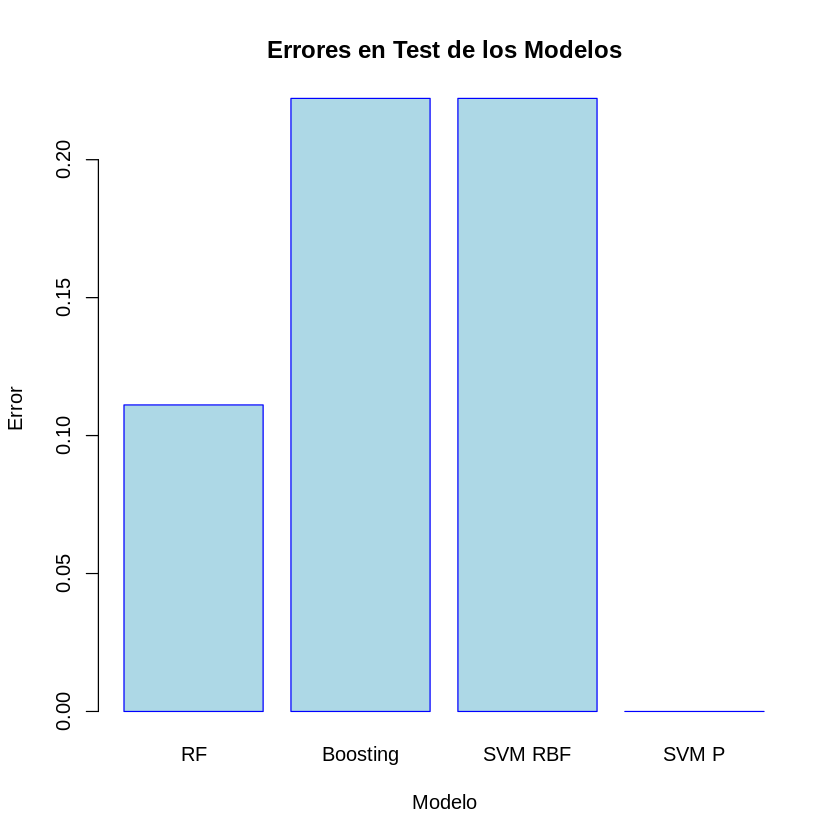

In [244]:
modelos <- c("RF", "Boosting", "SVM RBF", "SVM P")
errores_test <- c(min(final_results_rf$Test_Error), min(final_results_xgb$Test_Error), min(final_results_svmrbf$Test_Error), min(final_results_svmp$Test_Error))

barplot(height = errores_test,
        names.arg = modelos,
        xlab = "Modelo",
        ylab = "Error",
        col = "lightblue",
        border = "blue",
        main = "Errores en Test de los Modelos")

Claramente podemos ver que SVM Polinomial fue el de mejores resultados y despues de haber corrido el experimento muchas veces, esto suele ser asi siempre.

Un método con el que suelo no estar conforme es con Boosting ya que es muy variable entre las corridas del experimento, probablemente se deba a que por la falta de samples las estimaciones de los mejores parametros esten siendo malas, a veces ocurre que es el peor método y otras logra obtener 0% de error.

Random Forest en general me parece un muy buen método que siempre logra errores entre 0% y 11%, con la ventaja que es de los más rapidos para entrenar y el que tiene menos parámetros para optimizar.

SVM RBF siempre fue el peor método, obteniendo 22% de error como mínimo entre todas las corridas de todo el experimento que hice (que no fueron pocas).

Como análisis final que quiero hacer es que es muy difícil optimizar parametros y evaluarlos justamente cuando el dataset es muy pequeño ya que unos puntos sampleados distintos y cambian todos los resultados, siendo así, Random Forest me parece el mejor modelo ya que nos brinda el OOB error que nos da una muy buena cota superior, en este caso de 10,5% el cual se logró entrenando con solo los 40 puntos de train

# Ej 4

Correr este punto me tomo 42967 segundos (11 horas 56 minutos) sin contar una vez que lo corri con los parametros a probar equivocados.

Con este dataset va a ser mas fácil obtener buenas estimaciones en la optimizacion de parámetros ya que se tienen muchos mas samples, de todas formas decidí utilizar la misma metodología que en el punto anterior.

## Cargar Dataset

In [9]:
RRL <- RRL[sample(1:nrow(RRL)), ]

test_indices <- sample(1:nrow(RRL), size = (0.2 * nrow(RRL)))
test <- RRL[test_indices, ]
train <- RRL[-test_indices, ]

In [10]:
nrow(test)
nrow(train)

[1] 1412

[1] 5648

## Optimizacion de parámetros

### Random Forest

In [ ]:
results_rrl_rf <- data.frame(Mtry = numeric(), Error = numeric(), stringsAsFactors = FALSE)

mtry_values <- floor((ncol(train)-1) * (1 / 2)^(0:6))
errors_avg <- c()
tree_count <- 1000
num_runs <- 5

for (mtry in mtry_values) {
  errors <- numeric(num_runs)

  for (i in 1:num_runs) {
    rf_model <- randomForest(
      Tipo ~ .,
      data=train,
      mtry = mtry,
      ntree = tree_count
    )

    errors[i] <- rf_model$err.rate[nrow(rf_model$err.rate), "OOB"]
  }
  errors_avg <- c(errors_avg, mean(errors))
  results_rrl_rf <- rbind(results_rrl_rf, data.frame(Mtry = mtry, Error = errors_avg[length(errors_avg)]))
}

In [11]:
load("/content/results_rrl_rf.RData")

In [12]:
print(kable(results_rrl_rf, format.args = list(scientific = FALSE), align = "r"))



| Mtry|     Error|
|----:|---------:|
|   69| 0.0458924|
|   34| 0.0405453|
|   17| 0.0400496|
|    8| 0.0396955|
|    4| 0.0403683|
|    2| 0.0423159|
|    1| 0.0461048|


In [13]:
min_error <- min(results_rrl_rf$Error)
best_results_rf <- results_rrl_rf[results_rrl_rf$Error == min_error, ]
print(kable(best_results_rf, format.args = list(scientific = FALSE), align = "r"))



|   | Mtry|     Error|
|:--|----:|---------:|
|4  |    8| 0.0396955|


Al igual que en el ejercicio 2, el mejor mtry es 8, el valor más cercano a la raiz cuadrada de 69.

### XGBoosting

In [ ]:
results_rrl_xgb <- data.frame(LearningRate = numeric(), Prof = integer(), Error = numeric(), stringsAsFactors = FALSE)

nrounds <- 1000
learning_rates <- c(0.01, 0.05, 0.1, 0.3)
profs <- 1:20
num_folds <- 5
folds <- cut(seq(1, nrow(train)), breaks = num_folds, labels = FALSE)

for(i in 1:length(learning_rates)) {
  for(j in 1:length(profs)) {
    error_kfold <- k_fold_cv_xgboost(train, "Tipo", folds, learning_rates[i], nrounds, profs[j], num_folds)
    results_rrl_xgb <- rbind(results_rrl_xgb, data.frame(LearningRate = learning_rates[i], Prof = profs[j], Error = error_kfold))
  }
}

In [14]:
load("/content/results_rrl_xgb.RData")

In [15]:
print(kable(results_rrl_xgb, format.args = list(scientific = FALSE), align = "r"))



| LearningRate| Prof|     Error|
|------------:|----:|---------:|
|         0.01|    1| 0.0566547|
|         0.01|    2| 0.0501043|
|         0.01|    3| 0.0410751|
|         0.01|    4| 0.0423136|
|         0.01|    5| 0.0433760|
|         0.01|    6| 0.0479797|
|         0.01|    7| 0.0486881|
|         0.01|    8| 0.0515207|
|         0.01|    9| 0.0531141|
|         0.01|   10| 0.0529370|
|         0.01|   11| 0.0536443|
|         0.01|   12| 0.0541759|
|         0.01|   13| 0.0552379|
|         0.01|   14| 0.0548840|
|         0.01|   15| 0.0552393|
|         0.01|   16| 0.0555926|
|         0.01|   17| 0.0555926|
|         0.01|   18| 0.0555932|
|         0.01|   19| 0.0555923|
|         0.01|   20| 0.0548845|
|         0.05|    1| 0.0449688|
|         0.05|    2| 0.0446157|
|         0.05|    3| 0.0423145|
|         0.05|    4| 0.0428455|
|         0.05|    5| 0.0424909|
|         0.05|    6| 0.0470949|
|         0.05|    7| 0.0497503|
|         0.05|    8| 0.0492192|
|       

In [16]:
min_error <- min(results_rrl_xgb$Error)
best_results_xgb <- results_rrl_xgb[results_rrl_xgb$Error == min_error, ]
print(kable(best_results_xgb, format.args = list(scientific = FALSE), align = "r"))



|   | LearningRate| Prof|     Error|
|:--|------------:|----:|---------:|
|3  |         0.01|    3| 0.0410751|


Los parámetros optimos para XGBoosting fue de learning rate 0.01 y profundidad de 3.

Podemos confirmar que este método funciona con weaklearners, ya que para todos los learning rates, mientras mas grande es la profundidad de los árboles peores son los resultados.

### SVM - RBF

In [ ]:
results_rrl_svmrbf <- data.frame(Cost = numeric(),
                      Gamma = numeric(),
                      Error = numeric(),
                      stringsAsFactors = FALSE)

costs <- c(1, 10, 100, 1000, 10000, 100000)
gammas <- c(0.0000001, 0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10)
num_folds <- 5
folds <- cut(seq(1, nrow(train)), breaks = num_folds, labels = FALSE)

for(i in 1:length(costs)) {
  for(j in 1:length(gammas)) {
    suppressWarnings(error_kfold <- k_fold_cv_svm_RBF(train, "Tipo", folds, costs[i], gammas[j], num_folds))
    results_rrl_svmrbf <- rbind(results_rrl_svmrbf, data.frame(Cost = costs[i], Gamma = gammas[j], Error = error_kfold))
  }
}

In [17]:
load("/content/results_rrl_svmrbf.RData")

In [18]:
print(kable(results_rrl_svmrbf, format.args = list(scientific = FALSE), align = "r"))



|         Cost|     Gamma|     Error|
|------------:|---------:|---------:|
|      0.00001|  0.000001| 0.5070765|
|      0.00001|  0.000010| 0.5070765|
|      0.00001|  0.000100| 0.5070765|
|      0.00001|  0.001000| 0.5070765|
|      0.00001|  0.010000| 0.5070765|
|      0.00001|  0.100000| 0.5070765|
|      0.00001|  1.000000| 0.5070765|
|      0.00001| 10.000000| 0.5070765|
|      0.00010|  0.000001| 0.5070765|
|      0.00010|  0.000010| 0.5070765|
|      0.00010|  0.000100| 0.5070765|
|      0.00010|  0.001000| 0.5070765|
|      0.00010|  0.010000| 0.5070765|
|      0.00010|  0.100000| 0.5070765|
|      0.00010|  1.000000| 0.5070765|
|      0.00010| 10.000000| 0.5070765|
|      0.00100|  0.000001| 0.5070765|
|      0.00100|  0.000010| 0.5070765|
|      0.00100|  0.000100| 0.5070765|
|      0.00100|  0.001000| 0.5070765|
|      0.00100|  0.010000| 0.5070765|
|      0.00100|  0.100000| 0.5070765|
|      0.00100|  1.000000| 0.5070765|
|      0.00100| 10.000000| 0.5070765|
|      0.0

In [19]:
min_error <- min(results_rrl_svmrbf$Error)
best_results_svmrbf <- results_rrl_svmrbf[results_rrl_svmrbf$Error == min_error, ]
print(kable(best_results_svmrbf, format.args = list(scientific = FALSE), align = "r"))



|   | Cost| Gamma|     Error|
|:--|----:|-----:|---------:|
|68 | 1000| 0.001| 0.0844553|


Los mejores resultados los obtuvimos con un costo de 1000 y gamma 0.001, de todas formas comparando con XGBoosting obtuvimos el doble de error.

### SVM - Polinomial

In [ ]:
results_rrl_svmp <- data.frame(Cost = numeric(), Gamma = numeric(), Degree = integer(), Error = numeric(), stringsAsFactors = FALSE)

costs <- c(1, 10, 100, 1000, 10000, 100000)
gammas <- c(0.0000001, 0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10)
degrees <- 1:5
num_folds <- 5
folds <- cut(seq(1, nrow(train)), breaks = num_folds, labels = FALSE)

for(i in 1:length(costs)) {
  for(j in 1:length(gammas)) {
    for(k in 1:length(degrees)) {
      suppressWarnings(error_kfold <- k_fold_cv_svm_polinomial(train, "Tipo", folds, costs[i], gammas[j], degrees[k], num_folds))
      results_rrl_svmp <- rbind(results_rrl_svmp, data.frame(Cost = costs[i], Gamma = gammas[j], Degree = degrees[k], Error = error_kfold))
    }
  }
}

In [20]:
load("/content/results_rrl_svmp.RData")

In [21]:
print(kable(results_rrl_svmp, format.args = list(scientific = FALSE), align = "r"))



|         Cost|     Gamma| Degree|     Error|
|------------:|---------:|------:|---------:|
|      0.00001|  0.000001|      1| 0.5070765|
|      0.00001|  0.000001|      2| 0.5070765|
|      0.00001|  0.000001|      3| 0.5070765|
|      0.00001|  0.000001|      4| 0.5070765|
|      0.00001|  0.000001|      5| 0.5070765|
|      0.00001|  0.000010|      1| 0.5070765|
|      0.00001|  0.000010|      2| 0.5070765|
|      0.00001|  0.000010|      3| 0.5070765|
|      0.00001|  0.000010|      4| 0.5070765|
|      0.00001|  0.000010|      5| 0.5070765|
|      0.00001|  0.000100|      1| 0.5070765|
|      0.00001|  0.000100|      2| 0.5070765|
|      0.00001|  0.000100|      3| 0.5070765|
|      0.00001|  0.000100|      4| 0.5070765|
|      0.00001|  0.000100|      5| 0.5070765|
|      0.00001|  0.001000|      1| 0.5070765|
|      0.00001|  0.001000|      2| 0.5070765|
|      0.00001|  0.001000|      3| 0.5070765|
|      0.00001|  0.001000|      4| 0.5070765|
|      0.00001|  0.001000|      

In [22]:
min_error <- min(results_rrl_svmp$Error)
best_results_svmp <- results_rrl_svmp [results_rrl_svmp$Error == min_error, ]
print(kable(best_results_svmp, format.args = list(scientific = FALSE), align = "r"))



|    | Cost| Gamma| Degree|     Error|
|:---|----:|-----:|------:|---------:|
|276 |   10|    10|      1| 0.0936616|


Los mejores parametros los obtuvimos con costo 10, gamma 10 y grado 1, nuevamente el error es mucho peor que en los otros métodos.

## Comparación

Ahora corramos los distintos métodos con los mejores parámetros obtenidos y con todo el conjunto de train y comparemoslos entre ellos evaluando en test.

### RandomForest

In [23]:
final_results_rf <- data.frame(Mtry = numeric(),
                               Train_Error = numeric(),
                               Test_Error = numeric(),
                               stringsAsFactors = FALSE)
tree_count <- 1000

for (i in 1:nrow(best_results_rf)) {
  mtry <- best_results_rf$Mtry[i]

  rf_model <- randomForest(
    Tipo ~ .,
    data=train,
    mtry = mtry,
    ntree = tree_count
  )

  train_pred_rf <- predict(rf_model, train[, -ncol(train)])
  train_error_rf <- mean(train_pred_rf != train$Tipo)

  test_pred_rf <- predict(rf_model, test[, -ncol(test)])
  test_error_rf <- mean(test_pred_rf != test$Tipo)

  final_results_rf <- rbind(final_results_rf, data.frame(Mtry = mtry, Train_Error = train_error_rf, Test_Error = test_error_rf))
}

In [24]:
print(kable(final_results_rf, format.args = list(scientific = FALSE), align = "r"))



| Mtry| Train_Error| Test_Error|
|----:|-----------:|----------:|
|    8|           0|   0.036119|


### XGBoost

In [25]:
final_results_xgb <- data.frame(LearningRate = numeric(), Prof = integer(), Train_Error = numeric(), Test_Error = numeric(), stringsAsFactors = FALSE)

nrounds <- 1000

for (i in 1:nrow(best_results_xgb)) {
  # Obtener los parámetros de la fila actual
  best_lr <- best_results_xgb$LearningRate[i]
  best_max_depth <- best_results_xgb$Prof[i]

  # Entrenar el modelo XGBoost con los mejores parámetros
  m.xgb <- xgboost(
    data = as.matrix(train[, -ncol(train)]),
    label = as.integer(train$Tipo) - 1,
    objective = "binary:hinge",
    nrounds = nrounds,
    early_stopping_rounds = 1000,
    eta = best_lr,
    max.depth = best_max_depth,
    colsample_bytree = 1,
    verbose = 0,
    subsample = 1
  )

  train_pred_xgb <- predict(m.xgb, as.matrix(train[, -ncol(train)]))
  train_error_xgb <- mean(train_pred_xgb != (as.integer(train$Tipo) - 1))

  test_pred_xgb <- predict(m.xgb, as.matrix(test[, -ncol(test)]))
  test_error_xgb <- mean(test_pred_xgb != (as.integer(test$Tipo) - 1))

  final_results_xgb <- rbind(final_results_xgb, data.frame(LearningRate = best_lr,
                                                           Prof = best_max_depth,
                                                           Train_Error = train_error_xgb,
                                                           Test_Error = test_error_xgb))
}

In [26]:
print(kable(final_results_xgb, format.args = list(scientific = FALSE), align = "r"))



| LearningRate| Prof| Train_Error| Test_Error|
|------------:|----:|-----------:|----------:|
|         0.01|    3|   0.0194759|  0.0354108|


### SVM RBF

In [27]:
final_results_svmrbf <- data.frame(Cost = numeric(), Gamma = numeric(), Train_Error = numeric(), Test_Error = numeric(), stringsAsFactors = FALSE)

for (i in 1:nrow(best_results_svmrbf)) {
  # Obtener los parámetros de la fila actual
  best_cost <- best_results_svmrbf$Cost[i]
  best_gamma <- best_results_svmrbf$Gamma[i]

  # Entrenar el modelo SVM con los mejores parámetros
  suppressWarnings(svm_model <- svm(
    Tipo ~ .,
    data = train,
    type = 'C-classification',
    kernel = "radial",
    cost = best_cost,
    gamma = best_gamma
  ))

  train_pred_svmrbf <- predict(svm_model, train[, -ncol(train)])
  train_error_svmrbf <- mean(train_pred_svmrbf != train$Tipo)

  test_pred_svmrbf <- predict(svm_model, test[, -ncol(test)])
  test_error_svmrbf <- mean(test_pred_svmrbf != test$Tipo)

  # Guardar los resultados en el dataframe
  final_results_svmrbf <- rbind(final_results_svmrbf, data.frame(Cost = best_cost, Gamma = best_gamma, Train_Error = train_error_svmrbf, Test_Error = test_error_svmrbf))
}


In [28]:
print(kable(final_results_svmrbf, format.args = list(scientific = FALSE), align = "r"))



| Cost| Gamma| Train_Error| Test_Error|
|----:|-----:|-----------:|----------:|
| 1000| 0.001|   0.0435552|  0.0715297|


### SVM Polinomial

In [29]:
final_results_svmp <- data.frame(Cost = numeric(), Gamma = numeric(), Degree = integer(), Train_Error = numeric(), Test_Error = numeric(), stringsAsFactors = FALSE)

for (i in 1:nrow(best_results_svmp)) {
  best_cost <- best_results_svmp$Cost[i]
  best_gamma <- best_results_svmp$Gamma[i]
  best_degree <- best_results_svmp$Degree[i]

  suppressWarnings(svm_model <- svm(
    Tipo ~ .,
    data = train,
    type = 'C-classification',
    kernel = "polynomial",
    degree = best_degree,
    cost = best_cost,
    gamma = best_gamma
  ))

  train_pred_svmpol <- predict(svm_model, train[, -ncol(train)])
  train_error_svmpol <- mean(train_pred_svmpol != train$Tipo)

  test_pred_svmpol <- predict(svm_model, test[, -ncol(test)])
  test_error_svmpol <- mean(test_pred_svmpol != test$Tipo)

  final_results_svmp <- rbind(final_results_svmp, data.frame(Cost = best_cost, Gamma = best_gamma, Degree = best_degree, Train_Error = train_error_svmpol, Test_Error = test_error_svmpol))
}

In [30]:
print(kable(final_results_svmp, format.args = list(scientific = FALSE), align = "r"))



| Cost| Gamma| Degree| Train_Error| Test_Error|
|----:|-----:|------:|-----------:|----------:|
|   10|    10|      1|   0.0949008|  0.0871105|


### Gráfica

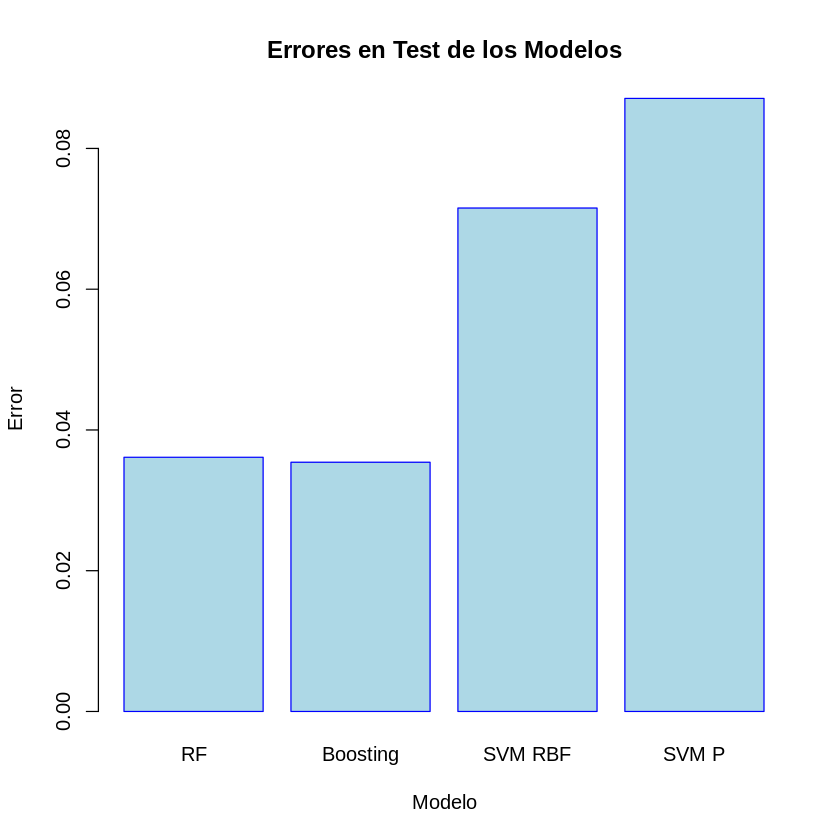

In [31]:
modelos <- c("RF", "Boosting", "SVM RBF", "SVM P")
errores_test <- c(min(final_results_rf$Test_Error), min(final_results_xgb$Test_Error), min(final_results_svmrbf$Test_Error), min(final_results_svmp$Test_Error))

barplot(height = errores_test,
        names.arg = modelos,
        xlab = "Modelo",
        ylab = "Error",
        col = "lightblue",
        border = "blue",
        main = "Errores en Test de los Modelos")

Podemos ver que XGBoosting fue el mejor método siguiendole muy cerca RandomForest, teniendo en cuenta que el tiempo para entrenar y optimizar los parámetros fue mucho menor para RandomForest, me sigue pareciendo el mejor método si no contamos con el tiempo para optimizar al máximo.

Los métodos de kernel obtuvieron errores bastante altos por lo que parece ser que para este problema no son particularmete útiles.